## 1. Exploring the Dataset Folder

In this step, we will check the folder path of the dataset on Kaggle.  
Our goal is to:  
- Confirm the correct folder path  
- View the file and subfolder structure within the dataset  


In [1]:
import os

# Define the dataset path
data_dir = "/kaggle/input/garbage-classification"

# List the contents of the dataset folder
print("Dataset içindeki klasörler ve dosyalar:")
print(os.listdir(data_dir))


Dataset içindeki klasörler ve dosyalar:
['garbage_classification']


## 2. Exploring the Class Folders

Our dataset actually contains a single main folder (`garbage_classification`).  
The images for each class are located in subfolders within this folder.  
In this step:
- We will list the class folders
- We will find out how many classes there are in total


In [2]:
# Update the path of the main class folder
main_dir = os.path.join(data_dir, "garbage_classification")

# List the subfolders (classes) inside
class_names = sorted(os.listdir(main_dir))
print("Sınıf isimleri:", class_names)
print("Toplam sınıf sayısı:", len(class_names))


Sınıf isimleri: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Toplam sınıf sayısı: 12


## 3. Class Distribution and Sample Images

In this step:
- We will count how many images are in each class
- We will check if there is any imbalance between classes
- We will visualize sample images from each class

The purpose of this is:
- To better understand the dataset
- To see which classes have more/less data before training the model
- To examine the resolution, quality, and content diversity of the images


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


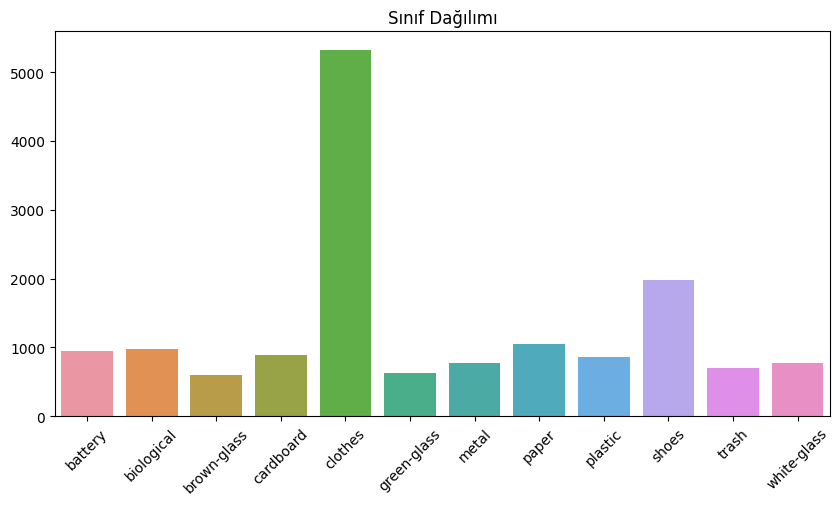

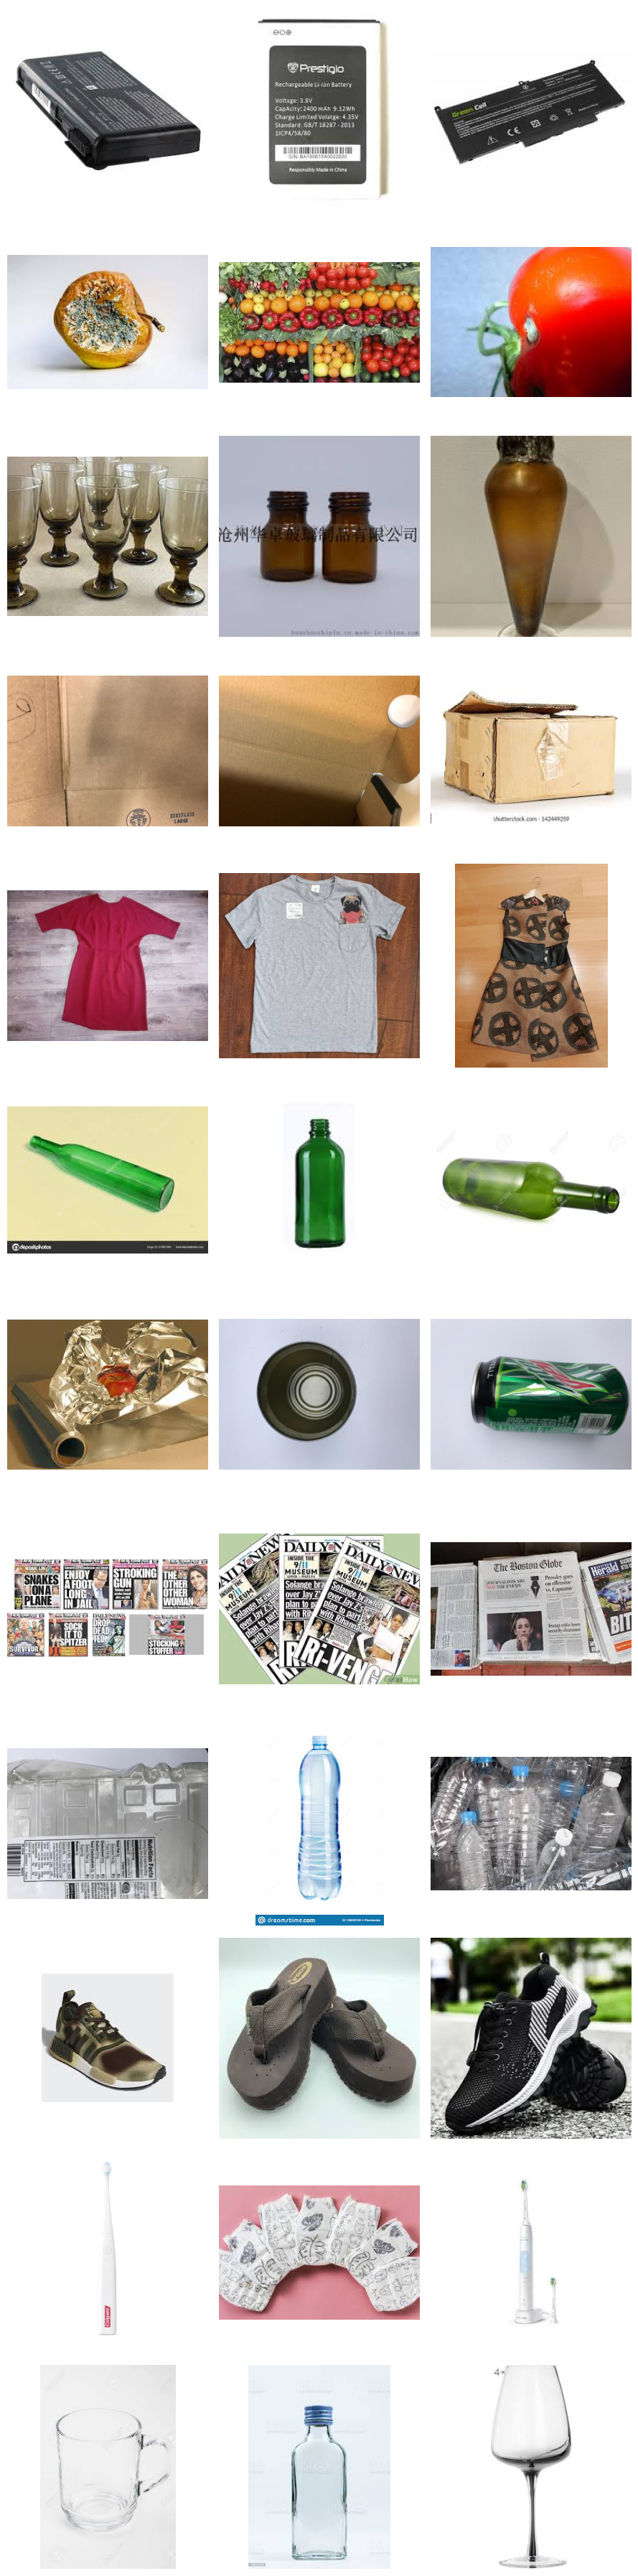

In [3]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# Calculate the number of images in each class
class_counts = {}
for cls in class_names:
    files = glob.glob(os.path.join(main_dir, cls, "*"))
    class_counts[cls] = len(files)

# Visualize
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Sınıf Dağılımı")
plt.show()

# Let's show sample images from each class
fig, axes = plt.subplots(len(class_names), 3, figsize=(9, 3*len(class_names)))

for i, cls in enumerate(class_names):
    files = glob.glob(os.path.join(main_dir, cls, "*"))
    sample = random.sample(files, min(3, len(files)))
    for j, f in enumerate(sample):
        img = Image.open(f).convert("RGB")
        axes[i,j].imshow(img)
        axes[i,j].axis("off")
        if j == 0:
            axes[i,j].set_ylabel(cls, rotation=0, labelpad=40, size=10)

plt.tight_layout()
plt.show()


## 4. Data Cleaning and Train/Validation/Test Split

- We will check whether the images are readable (are there any corrupted files).
- We will split the data into Train / Validation / Test sets.
  - Train: Data used to train the model (70%)
  - Validation: Data used to validate the model during training (15%)
  - Test: Data reserved for final evaluation (15%)

This allows us to measure the model's “generalization” performance.


In [4]:
from sklearn.model_selection import train_test_split

# Create file paths and tag labels
file_paths = []
labels = []

for label_idx, cls in enumerate(class_names):
    cls_files = glob.glob(os.path.join(main_dir, cls, "*"))
    for fp in cls_files:
        file_paths.append(fp)
        labels.append(label_idx)

print("Toplam görüntü:", len(file_paths))

# Train / Val / Test splitting (70/15/15)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels, test_size=0.30, stratify=labels, random_state=123
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=123
)

print("Train set:", len(train_paths))
print("Validation set:", len(val_paths))
print("Test set:", len(test_paths))


Toplam görüntü: 15515
Train set: 10860
Validation set: 2327
Test set: 2328


## 5. Data Augmentation

It is important to diversify the training data to prevent the model from overfitting.  
Data augmentation allows for:
- Image rotation
- Mirroring (flip)
- Zooming in/out
- Contrast/brightness changes (color jitter)

increase the diversity of the training data.  
These transformations are applied **only to the train set**.  
The validation and test sets remain **original**.


In [5]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split


# Settings

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
DATASET_PATH = "/kaggle/input/garbage-classification/garbage_classification"

print("Path exists:", os.path.exists(DATASET_PATH))
print("Contents:", os.listdir(DATASET_PATH))


# Data Augmentation pipeline

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),   # Random horizontal flip
    layers.RandomRotation(0.1),        # Random rotation up to 10%
    layers.RandomZoom(0.1),            # Random zoom up to 10%
    layers.RandomContrast(0.1)         # Random contrast adjustment
], name="data_augmentation")


# Image loading and resizing function

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]
    return img, label


# Dataset creation function

def build_dataset(paths, labels, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    if is_training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds


# Extract image paths and labels

def get_image_paths_and_labels(base_path):
    class_names = sorted(os.listdir(base_path))  # List class names alphabetically
    paths = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(base_path, class_name)
        for fname in os.listdir(class_folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(class_folder, fname))
                labels.append(idx)
    return paths, labels, class_names


# Split dataset into train/val/test

all_paths, all_labels, class_names = get_image_paths_and_labels(DATASET_PATH)

# 70% train, 15% val, 15% test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print("Classes:", class_names)
print("Train:", len(train_paths), "Val:", len(val_paths), "Test:", len(test_paths))


# Create TensorFlow datasets

train_ds = build_dataset(train_paths, train_labels, is_training=True)
val_ds = build_dataset(val_paths, val_labels, is_training=False)
test_ds = build_dataset(test_paths, test_labels, is_training=False)


2025-09-25 16:18:50.985153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758817131.003521     607 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758817131.010374     607 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path exists: True
Contents: ['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


I0000 00:00:1758817134.091142     607 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758817134.091823     607 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Train: 10860 Val: 2327 Test: 2328


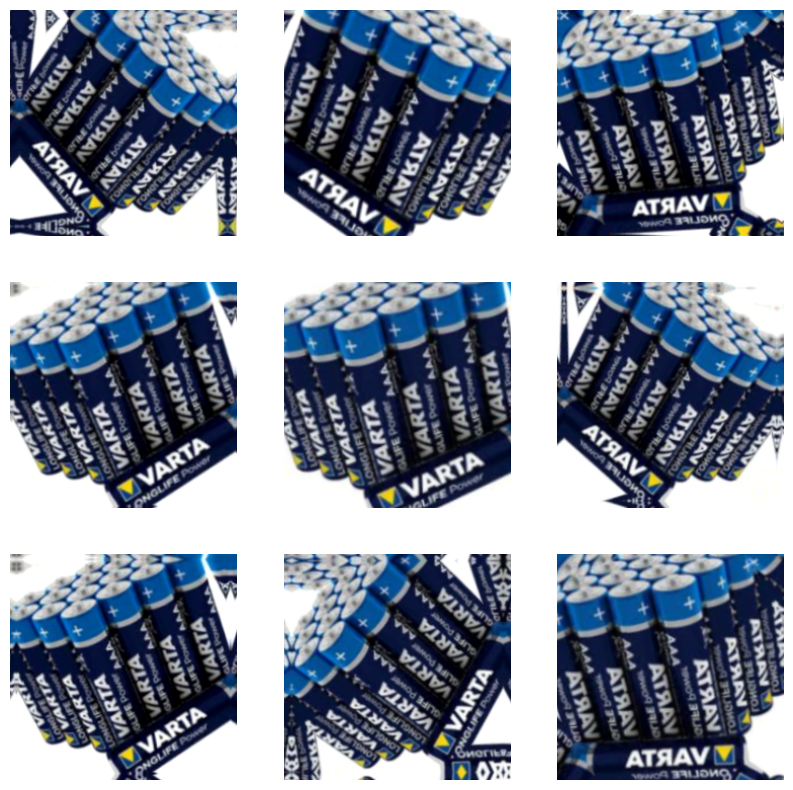

In [82]:
import matplotlib.pyplot as plt
import tensorflow as tf


# Take a single batch from the training dataset

# train_ds: previously created TensorFlow dataset with batches
for images, labels in train_ds.take(1):
    
    # Select the first image from the batch
    sample_img = images[0]  # shape: (224, 224, 3), still a tensor
    
    # Convert tensor to numpy array for easier plotting and augmentation
    # This removes the batch dimension, shape stays (224, 224, 3)
    sample_img_np = sample_img.numpy()
    
    
    # Create a 3x3 grid to display augmented images
    
    plt.figure(figsize=(10,10))
    
    # Loop 9 times to generate 9 different augmentations of the same image
    for i in range(9):
        # Apply data augmentation
        # training=True ensures that random transformations (flip, rotate, zoom, contrast) are applied
        augmented_img = data_augmentation(sample_img_np, training=True)
        
        # Create a subplot in the 3x3 grid
        plt.subplot(3,3,i+1)
        
        # Display the augmented image
        plt.imshow(augmented_img)
        
        # Turn off axis labels for better visualization
        plt.axis("off")
    
    # Show all 9 augmented images
    plt.show()


## 6. System Preparation and Statistics Collection

**Purpose:** To optimize GPU memory settings and collect basic statistics about the dataset.

**Processes:**
- Enable GPU memory growth (prevent OOM errors)
- List class names in sorted order
- Calculate the total number of classes
- Estimate the number of training/validation/test samples (using multiple methods)

In [7]:
import tensorflow as tf
import numpy as np
import os

# Set your main dataset folder
main_dir = "/kaggle/input/garbage-classification/garbage_classification"

# List all class names (subfolders)
class_names = sorted([folder for folder in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, folder))])

print("Classes:", class_names)

# Optional: allow GPU memory growth to avoid OOM / driver warnings
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except RuntimeError as e:
        print("GPU config error:", e)

# Number of classes
num_classes = len(class_names)
print("Number of classes:", num_classes)

# Try to get counts (fall back if variables not present)
try:
    train_count = len(train_paths)
    val_count = len(val_paths)
    test_count = len(test_paths)
except Exception:
    # fallback using dataset cardinality
    try:
        train_count = int(tf.data.experimental.cardinality(train_ds).numpy())
        val_count = int(tf.data.experimental.cardinality(val_ds).numpy())
        test_count = int(tf.data.experimental.cardinality(test_ds).numpy())
    except Exception:
        train_count = val_count = test_count = None

print("Train count:", train_count, "Val count:", val_count, "Test count:", test_count)


Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
GPU config error: Physical devices cannot be modified after being initialized
Number of classes: 12
Train count: 10860 Val count: 2327 Test count: 2328


## 7.CUSTOM CNN (from-scratch)

The following model contains a simple, instructive CNN architecture: Conv → Pool → Dropout → Dense. These components fulfill the desired elements (Convolutional, Pooling, Dropout, Dense, ReLU/Softmax).
Explanation:

Conv2D + BatchNorm: accelerates learning, provides stabilization.

MaxPooling2D: reduces spatial dimension, extracts local summaries.

Dropout: reduces overfitting.

GlobalAveragePooling: reduces the number of parameters, provides a summary before Dense.

Final Dense + softmax: provides class probabilities.

In [8]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    """Build a small CNN from scratch with conv/pool/dropout/dense layers."""
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.15)(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Global pooling + Dense
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="custom_cnn")
    return model

# Build and compile
custom_model = build_custom_cnn()
custom_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,204 (438.30 KB)

 Trainable params: 111,756 (436.55 KB)

 Non-trainable params: 448 (1.75 KB)

## 8.B.1 Train (custom CNN)
Description: We added early stopping with EarlyStopping, saving the best weights with ModelCheckpoint, and reducing the learning rate on plateaus with ReduceLROnPlateau. train_ds is already batch-sized and includes augmentation.

In [9]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint('/kaggle/working/custom_cnn_best.h5', save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Train parameters
EPOCHS = 20

# Fit (we pass tf.data datasets directly)
history_custom = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20


I0000 00:00:1758817151.586281     646 service.cc:148] XLA service 0x1dcdd620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758817151.586317     646 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758817151.586322     646 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758817152.019673     646 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/340 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.0859 - loss: 2.8082   

I0000 00:00:1758817159.094708     646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4490 - loss: 1.7375
Epoch 1: val_loss improved from inf to 2.14084, saving model to /kaggle/working/custom_cnn_best.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 90s 217ms/step - accuracy: 0.4492 - loss: 1.7369 - val_accuracy: 0.3507 - val_loss: 2.1408 - learning_rate: 0.0010
Epoch 2/20
339/340 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5625 - loss: 1.3390
Epoch 2: val_loss improved from 2.14084 to 1.48765, saving model to /kaggle/working/custom_cnn_best.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 70s 193ms/step - accuracy: 0.5625 - loss: 1.3389 - val_accuracy: 0.5213 - val_loss: 1.4877 - learning_rate: 0.0010
Epoch 3/20
339/340 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5860 - loss: 1.2588
Epoch 3: val_loss improved from 1.48765 to 1.46754, saving model to /kaggle/working/custom_cnn_best.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 70s 192ms/step - accuracy: 0.5861 - loss: 1.2587 - val_accuracy: 0.5608 - val_loss: 1.4675 - learning_rate: 0.0010
Epoch 4/20

## 9.B.2 Evaluate (custom CNN) — test set performance + classification report
**Purpose:** To measure the model's final success on the test set and provide detailed class-based analysis.

**Outputs:**
- Test loss and accuracy values
- Precision, recall, f1-score for each class
- Class-based sample counts (support)
- Classes where the model performs well/poorly


In [10]:
# Evaluate on test set
test_results = custom_model.evaluate(test_ds)
print("Test loss, Test accuracy:", test_results)

# Optional: classification report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []
for X_batch, y_batch in test_ds:
    preds = custom_model.predict(X_batch)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(y_batch.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=class_names))


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6909 - loss: 1.0179
Test loss, Test accuracy: [0.966708242893219, 0.7023195624351501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

## 10. C — TRANSFER LEARNING (Bonus)
Transfer learning steps:

1. Load pre-trained base model (ImageNet) → freeze → add new classifier on top → train.

2. (Fine-tuning) Unfreeze some layers → retrain with low LR.

Explanation: We used preprocess_input(img * 255.) in Lambda because preprocess_input adjusts according to the expected scale (since our images are [0,1], we multiply by *255 first). We set trainable=False for the base model initially (we use it as a feature extractor).

In [11]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda

# Create TL model using EfficientNetB0 as example
def build_transfer_model(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    # Convert inputs from [0,1] -> [0,255] and apply EfficientNet preprocessing inside model
    x = Lambda(lambda img: tf.keras.applications.efficientnet.preprocess_input(img * 255.0))(inputs)

    # Base model (no top)
    base = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base.trainable = False  # freeze base for initial training

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="efficientnetb0_tl")
    return model

tl_model = build_transfer_model()
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0_tl"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ lambda[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,380,591 (16.71 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 11.C.1 Train top layers (transfer)
Explanation: At this stage, we are only training the head (classifier) parts; the base model is frozen.

In [12]:
# Callbacks (another checkpoint for TL)
callbacks_tl = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/kaggle/working/tl_efficientnetb0_top.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

EPOCHS_TOP = 8

history_tl_top = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_TOP,
    callbacks=callbacks_tl
)


Epoch 1/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 114s 241ms/step - accuracy: 0.1832 - loss: 1381.1759 - val_accuracy: 0.3434 - val_loss: 2.3799 - learning_rate: 0.0010
Epoch 2/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 65s 175ms/step - accuracy: 0.3340 - loss: 9.0174 - val_accuracy: 0.3434 - val_loss: 2.2749 - learning_rate: 0.0010
Epoch 3/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 175ms/step - accuracy: 0.3402 - loss: 4.8265 - val_accuracy: 0.3434 - val_loss: 2.2203 - learning_rate: 0.0010
Epoch 4/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 65s 177ms/step - accuracy: 0.3396 - loss: 3.6189 - val_accuracy: 0.3434 - val_loss: 2.1936 - learning_rate: 0.0010
Epoch 5/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 174ms/step - accuracy: 0.3433 - loss: 3.0202 - val_accuracy: 0.3434 - val_loss: 2.1825 - learning_rate: 0.0010
Epoch 6/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 65s 176ms/step - accuracy: 0.3417 - loss: 2.8211 - val_accuracy: 0.3434 - val_loss: 2.1787 - learning_rate: 0.0010
Epoch 7/8
340/340 ━━━━━━━━━━━━━━━━━━━━ 66s 179ms/step - accuracy: 0.3430

## 12.C.2 Fine-tuning (unfreeze some layers)
Explanation: For fine-tuning, a smaller LR (e.g., 1e-5) is generally used, and only the top (relatively deeper) layers are left open. The freeze_until value determines which layers will remain frozen; this number is set experimentally.

In [13]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
import tensorflow as tf

def build_transfer_model(input_shape=(224,224,3), num_classes=12):
    inputs = Input(shape=input_shape)
    x = Lambda(lambda img: tf.keras.applications.efficientnet.preprocess_input(img * 255.0))(inputs)

    # Let's also rotate the base model here
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet', input_tensor=x
    )
    base_model.trainable = False  

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="efficientnetb0_tl")
    return model, base_model   # 👈 hem transfer modeli hem base_model döndürelim

# Get the model and base model
tl_model, base_model = build_transfer_model()

# Use the base_model for fine-tuning
print("Before unfreezing:", base_model.trainable)

freeze_until = 200
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= freeze_until)

print("After unfreezing:")
for i, layer in enumerate(base_model.layers[:250]):
    print(i, layer.name, layer.trainable)

# Compile et
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Before unfreezing: False
After unfreezing:
0 input_layer_3 False
1 lambda_1 False
2 rescaling_2 False
3 normalization_1 False
4 rescaling_3 False
5 stem_conv_pad False
6 stem_conv False
7 stem_bn False
8 stem_activation False
9 block1a_dwconv False
10 block1a_bn False
11 block1a_activation False
12 block1a_se_squeeze False
13 block1a_se_reshape False
14 block1a_se_reduce False
15 block1a_se_expand False
16 block1a_se_excite False
17 block1a_project_conv False
18 block1a_project_bn False
19 block2a_expand_conv False
20 block2a_expand_bn False
21 block2a_expand_activation False
22 block2a_dwconv_pad False
23 block2a_dwconv False
24 block2a_bn False
25 block2a_activation False
26 block2a_se_squeeze False
27 block2a_se_reshape False
28 block2a_se_reduce False
29 block2a_se_expand False
30 block2a_se_excite False
31 block2a_project_conv False
32 block2a_project_bn False
33 block2b_expand_conv False
34 block2b_expand_bn False
35 block2b_expand_activation False
36 block2b_dwconv False
37 bloc

## 13. C.3 Evaluate TL model
**Objective:** To measure the final performance of the fine-tuned TL model on the test set.

**Outputs:**
- Test loss and accuracy values
- Detailed class-based metrics (precision, recall, f1-score)

In [14]:
# Evaluate on test set
test_results_tl = tl_model.evaluate(test_ds)
print("TL model - Test loss, Test accuracy:", test_results_tl)

# Optional classification report
y_true = []
y_pred = []
for X_batch, y_batch in test_ds:
    preds = tl_model.predict(X_batch)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(y_batch.numpy().tolist())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))


73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.0678 - loss: 2493.5149
TL model - Test loss, Test accuracy: [2466.2880859375, 0.07259450107812881]
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

## 14. Modelin Değerlendirilmesi
4.1. Visualizing training curves (Accuracy & Loss)


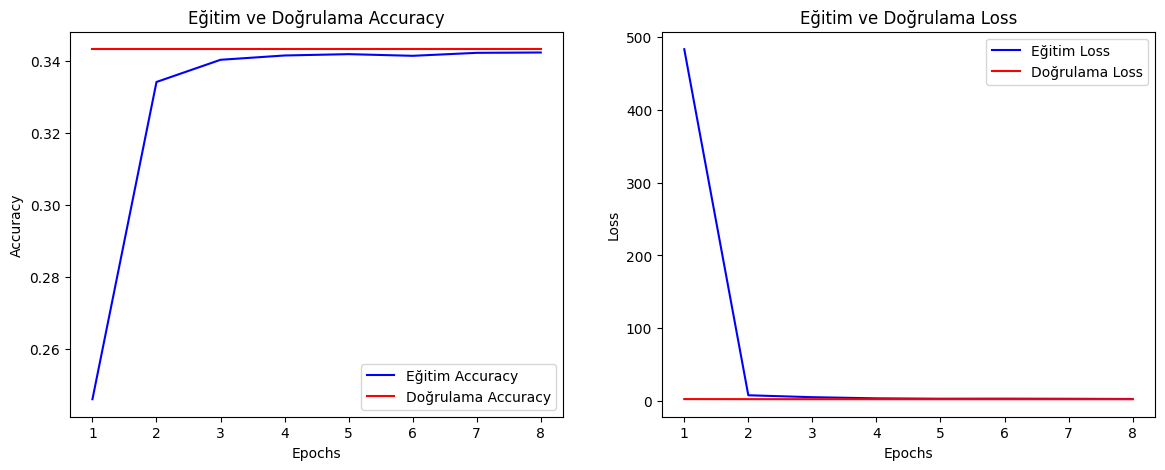

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    hist = history.history if hasattr(history, 'history') else history
    
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy graph
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Eğitim Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Doğrulama Accuracy')
    plt.title('Eğitim ve Doğrulama Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss graph
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Eğitim Loss')
    plt.plot(epochs, val_loss, 'r-', label='Doğrulama Loss')
    plt.title('Eğitim ve Doğrulama Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_training_history(history_tl_top)


## 15. 4.2 Detailed Model Analysis: Confusion Matrix & Classification Report

* Purpose: To analyze the model's class-based performance visually and numerically

* Outputs:
- Test Loss and Accuracy values
- Confusion Matrix visualization
- Detailed classification report

**Tools Used:**
- `sklearn.metrics`: Confusion matrix and classification report
- `seaborn`: Heatmap visualization
- `matplotlib`: Graph settings

✅ X_test shape: (2328, 224, 224, 3)
✅ y_test shape: (2328,)
✅ Test Loss: 4.3228
✅ Test Accuracy: 0.0460
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


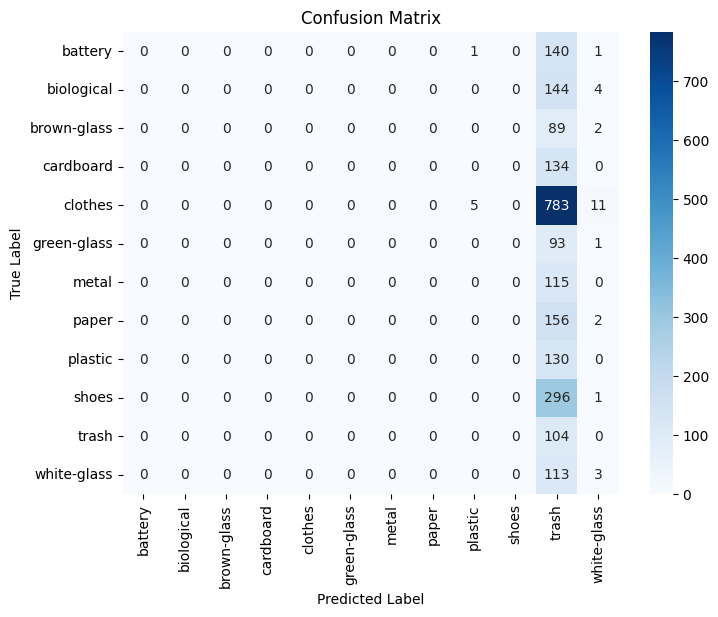

Classification Report:

              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       142
  biological       0.00      0.00      0.00       148
 brown-glass       0.00      0.00      0.00        91
   cardboard       0.00      0.00      0.00       134
     clothes       0.00      0.00      0.00       799
 green-glass       0.00      0.00      0.00        94
       metal       0.00      0.00      0.00       115
       paper       0.00      0.00      0.00       158
     plastic       0.00      0.00      0.00       130
       shoes       0.00      0.00      0.00       297
       trash       0.05      1.00      0.09       104
 white-glass       0.12      0.03      0.04       116

    accuracy                           0.05      2328
   macro avg       0.01      0.09      0.01      2328
weighted avg       0.01      0.05      0.01      2328



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Loading the test set

def load_images(file_paths, labels, img_size=224):
    data = []
    for fp in file_paths:
        img = load_img(fp, target_size=(img_size, img_size))
        img_array = img_to_array(img) / 255.0   # normalize [0,1]
        data.append(img_array)
    return np.array(data), np.array(labels)

X_test, y_test = load_images(test_paths, test_labels, img_size=IMG_SIZE)

print("✅ X_test shape:", X_test.shape)
print("✅ y_test shape:", y_test.shape)


# Test Loss & Accuracy

test_loss, test_accuracy = custom_model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


# Tahminler & Confusion Matrix

y_pred_probs = custom_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))


## 16. 4.3 Eğitim Grafikleri & Hata Analizi

**Amaç:** Modelin eğitim sürecini görselleştirmek ve hatalı tahminleri analiz etmek

**Eğitim Grafikleri:**
- Accuracy Trendi: Train vs Validation karşılaştırması
- Loss Trendi: Modelin öğrenme sürecinin izlenmesi
- Overfitting/Underfitting tespiti

**Hatalı Sınıflandırmalar:**
-  Yanlış tahmin edilen örneklerin görselleştirilmesi
-  Hata pattern'lerinin analizi
-  Model iyileştirme için insights elde etme

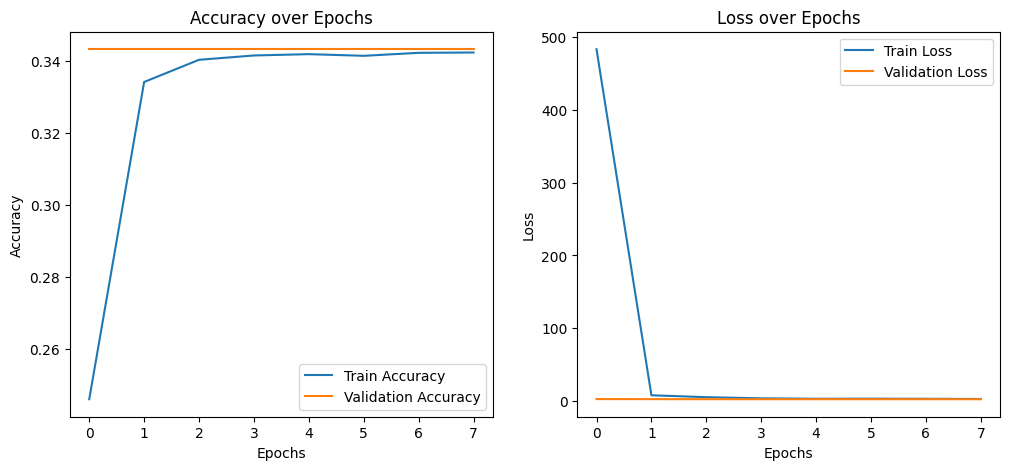

In [63]:
# Accuracy & Loss graph (history_tl_top üzerinden)
plt.figure(figsize=(12,5))

# Accuracy graph
plt.subplot(1,2,1)
plt.plot(history_tl_top.history['accuracy'], label='Train Accuracy')
plt.plot(history_tl_top.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss graph
plt.subplot(1,2,2)
plt.plot(history_tl_top.history['loss'], label='Train Loss')
plt.plot(history_tl_top.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


## 17. 4.4 Visual Analysis of Model Decisions with Grad-CAM

**Objective:** To visualize which areas of the image the CNN model looks at when classifying

**Technique:** Gradient-weighted Class Activation Mapping (Grad-CAM)

**Outputs:**
- Comparison of the original image and Grad-CAM heatmap
- Red tones: Critical regions the model focuses on
- Interpretability analysis of the model's decision mechanism

**Process Flow:**
1. Find the last convolutional layer
2. Calculate the gradients of the class scores
3. Weight the activation maps
4. Create the heatmap and overlay it on the image

/tmp/ipykernel_607/2485660522.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap(cmap)


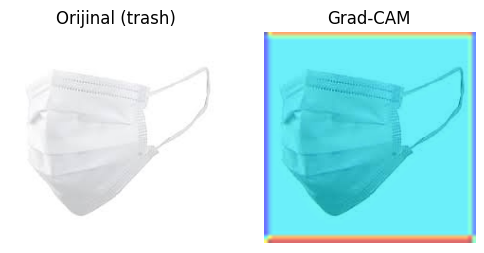

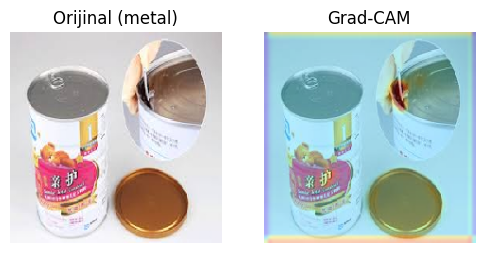

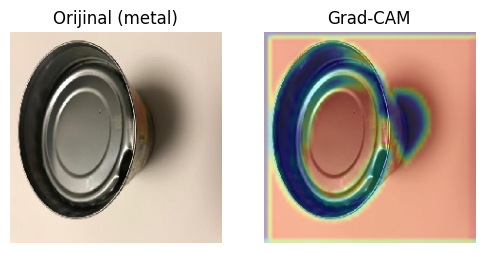

In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array


# Son Conv2D Katmanını bulma

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if 'conv' in layer.name or layer.__class__.__name__.lower().startswith('conv'):
            return layer.name
    raise ValueError('Model içinde Conv2D katmanı bulunamadı.')


# Grad-CAM Heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer(model)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


# Heatmap'i görsele bindirme

def overlay_heatmap(img, heatmap, alpha=0.4, cmap='jet'):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap(cmap)
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    img = img.copy()
    if img.max() <= 1.0:
        img = img * 255.0

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)
    return superimposed_img


# Test setinden birkaç örnek görselleştirme

for i in range(3):  # ilk 3 test örneği
    img = X_test[i]
    img_input = np.expand_dims(img, axis=0)

    heatmap = make_gradcam_heatmap(img_input, custom_model)
    overlay = overlay_heatmap((img*255).astype('uint8'), heatmap)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Orijinal ({class_names[y_test[i]]})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.show()


## 18. 5. Hyperparameter Optimization

**Objective:** To find the best parameter combination that maximizes model performance

**Method:** Scanning the parameter space using systematic search algorithms

**Parameters to Optimize:**
- Learning rate - Batch size
- Optimizer type
- Dropout rate
- Layer configurations

**Expected Benefits:**
- Higher accuracy
- Faster convergence
- Better generalization
- Resource efficiency

## 19. 5.1 Data Preparation

In [66]:
import tensorflow as tf
import numpy as np
AUTOTUNE = tf.data.AUTOTUNE

def parse_and_preprocess(path, label, img_size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_tf_dataset(paths, labels, img_size=IMG_SIZE, batch_size=32, is_training=False, augment_fn=None):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, l: parse_and_preprocess(p, l, img_size=img_size), num_parallel_calls=AUTOTUNE)
    if is_training and augment_fn is not None:
        ds = ds.map(lambda x,y: (augment_fn(x, training=True), y), num_parallel_calls=AUTOTUNE)
    if is_training:
        ds = ds.shuffle(buffer_size=2048, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# augmentation katmanı varsa kullan
try:
    augment_fn = data_augmentation
except:
    augment_fn = None

train_ds = make_tf_dataset(train_paths, train_labels, batch_size=32, is_training=True, augment_fn=augment_fn)
val_ds   = make_tf_dataset(val_paths, val_labels, batch_size=32, is_training=False)
test_ds  = make_tf_dataset(test_paths, test_labels, batch_size=32, is_training=False)


## 20. 5.2 Automatic Search with Keras Tuner
   5.2.1 Installing Keras Tuner

In [67]:
try:
    import keras_tuner as kt
except:
    !pip install -q keras-tuner
    import keras_tuner as kt


5.2.2 Model Builder

In [69]:
from tensorflow.keras import layers, models, regularizers, optimizers

def build_model_with_hp(hp):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    n_conv_blocks = hp.Int("conv_blocks", 2, 4, step=1)
    base_filters = hp.Choice("base_filters", values=[16, 32, 64])
    kernel_size = hp.Choice("kernel_size", values=[3, 5])
    l2_reg = hp.Float("l2_reg", 1e-6, 1e-3, sampling="log")
    dropout_rate = hp.Float("dropout", 0.1, 0.5, step=0.05)
    dense_units = hp.Choice("dense_units", values=[64, 128, 256, 512])

    x = inputs
    filters = base_filters
    for i in range(n_conv_blocks):
        x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same',
                          activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(dropout_rate)(x)
        filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    opt_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    if opt_choice == "adam":
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_choice == "rmsprop":
        opt = optimizers.RMSprop(learning_rate=lr)
    else:
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


5.2.3 Tuner Search

In [71]:
tuner = kt.RandomSearch(
    build_model_with_hp,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="garbage_classification"
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

tuner.search(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)


Trial 3 Complete [00h 20m 47s]
val_accuracy: 0.6974645256996155

Best val_accuracy So Far: 0.7550494074821472
Total elapsed time: 01h 17m 14s


## 21. 5.4 Optimize Model Training

**Objective:** Train the model using the best hyperparameters found by the tuner

**Steps:**
- Obtain the best model from the tuner
- Compile with the Adam optimizer
- Train for 20 epochs with early stopping
- Plot and analyze the curves

**Output:** Overfitting/underfitting check + optimized model performance

In [78]:
# --- Getting the Best Model from Keras Tuner ---
best_model = tuner.get_best_models(num_models=1)[0]

# --- Rebuild the model (may be required in some tuner configurations) ---
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Model Summary ---
best_model.summary()

# --- Training the Best Model ---
history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

# --- Draw Training/Validation Curves ---
plot_train_val_curves(history_best, title="Best Model (Keras Tuner)")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,065,484 (4.06 MB)

 Trainable params: 1,064,588 (4.06 MB)

 Non-trainable params: 896 (3.50 KB)

NameError: name 'X_train' is not defined

5.5 Test Değerlendirmesi

In [79]:
test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")


73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.7415 - loss: 0.8974
✅ Test Loss: 0.8925
✅ Test Accuracy: 0.7491


5.6 Confusion Matrix ve Classification Report

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
              precision    recall  f1-score   support

     battery       0.69      0.42      0.52       142
  biological       0.85      0.66      0.74       148
 brown-glass       0.92      0.59      0.72        91
   cardboard       0.83      0.75      0.79       134
     clothes       0.77      0.98      0.86       799
 green-glass       0.88      0.76      0.81        94
       metal       0.55      0.39      0.46       115
       paper       0.42      0.79      0.55       158
     plastic       0.53      0.55      0.54       130
       shoes       0.79      0.38      0.51       297
       trash       0.71      0.68      0.70       104
 white-glass       0.79      0.59      0.68       116

    accuracy                           0.71      2328
   macro avg       0.73      0.63      0.66      2328
weighted avg       0.74      0.71      0.70      2328



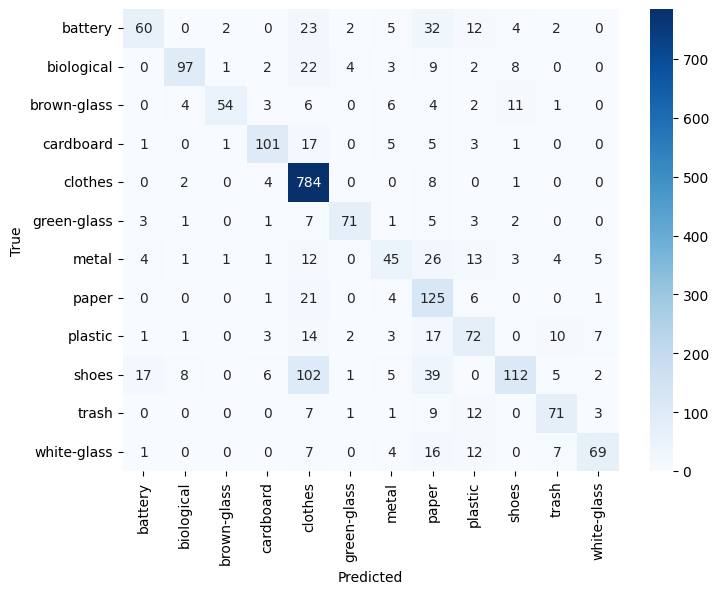

In [80]:
y_probs = best_model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test, y_preds, target_names=class_names))

cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


5.7 Bonus: TensorBoard Entegrasyonu

In [81]:
logdir = "logs/hp_search"
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir)

best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tensorboard_cb]
)



Epoch 1/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 108s 264ms/step - accuracy: 0.6959 - loss: 1.0421 - val_accuracy: 0.4615 - val_loss: 2.6231
Epoch 2/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 94s 247ms/step - accuracy: 0.7035 - loss: 1.0291 - val_accuracy: 0.5329 - val_loss: 1.6470
Epoch 3/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 246ms/step - accuracy: 0.7214 - loss: 0.9964 - val_accuracy: 0.5294 - val_loss: 1.9451
Epoch 4/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 245ms/step - accuracy: 0.7247 - loss: 0.9975 - val_accuracy: 0.3571 - val_loss: 5.8721
Epoch 5/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 246ms/step - accuracy: 0.7259 - loss: 0.9890 - val_accuracy: 0.5002 - val_loss: 1.6681
Epoch 6/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 244ms/step - accuracy: 0.7491 - loss: 0.9418 - val_accuracy: 0.4009 - val_loss: 2.7290
Epoch 7/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 245ms/step - accuracy: 0.7558 - loss: 0.9137 - val_accuracy: 0.2265 - val_loss: 5.2348
Epoch 8/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 93s 244ms/step - accuracy: 0.7591 - loss: 